In [2]:
import numpy as np
import os,sys
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt
import pathlib

current_directory = os.getcwd()
__dir__ = pathlib.Path(current_directory)
sys.path.append(str(__dir__.parent))


from modules.xfeat import XFeat

xfeat = XFeat()


loading weights from: /mnt/disk3/projects/expore/accelerated_features/modules/../weights/xfeat.pt


/home/lenovo/anaconda3/envs/xfeat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
im1 = cv2.imread('/mnt/disk3/projects/expore/accelerated_features/assets/ref.png')
im2 = cv2.imread('/mnt/disk3/projects/expore/accelerated_features/assets/tgt.png')
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1,im2,top_k=4096)
mkpts_0.shape, mkpts_1.shape

((832, 2), (832, 2))

In [39]:
im1 = cv2.imread('/mnt/disk3/projects/expore/accelerated_features/assets/ref.png')
im2 = cv2.imread('/mnt/disk3/projects/expore/accelerated_features/assets/tgt.png')
res1 = xfeat.detectAndCompute(im1)[0]
# len(res) # 1
# res["keypoints"].shape, res["scores"].shape, res["descriptors"].shape
# (torch.Size([4096, 2]), torch.Size([4096]), torch.Size([4096, 64]))

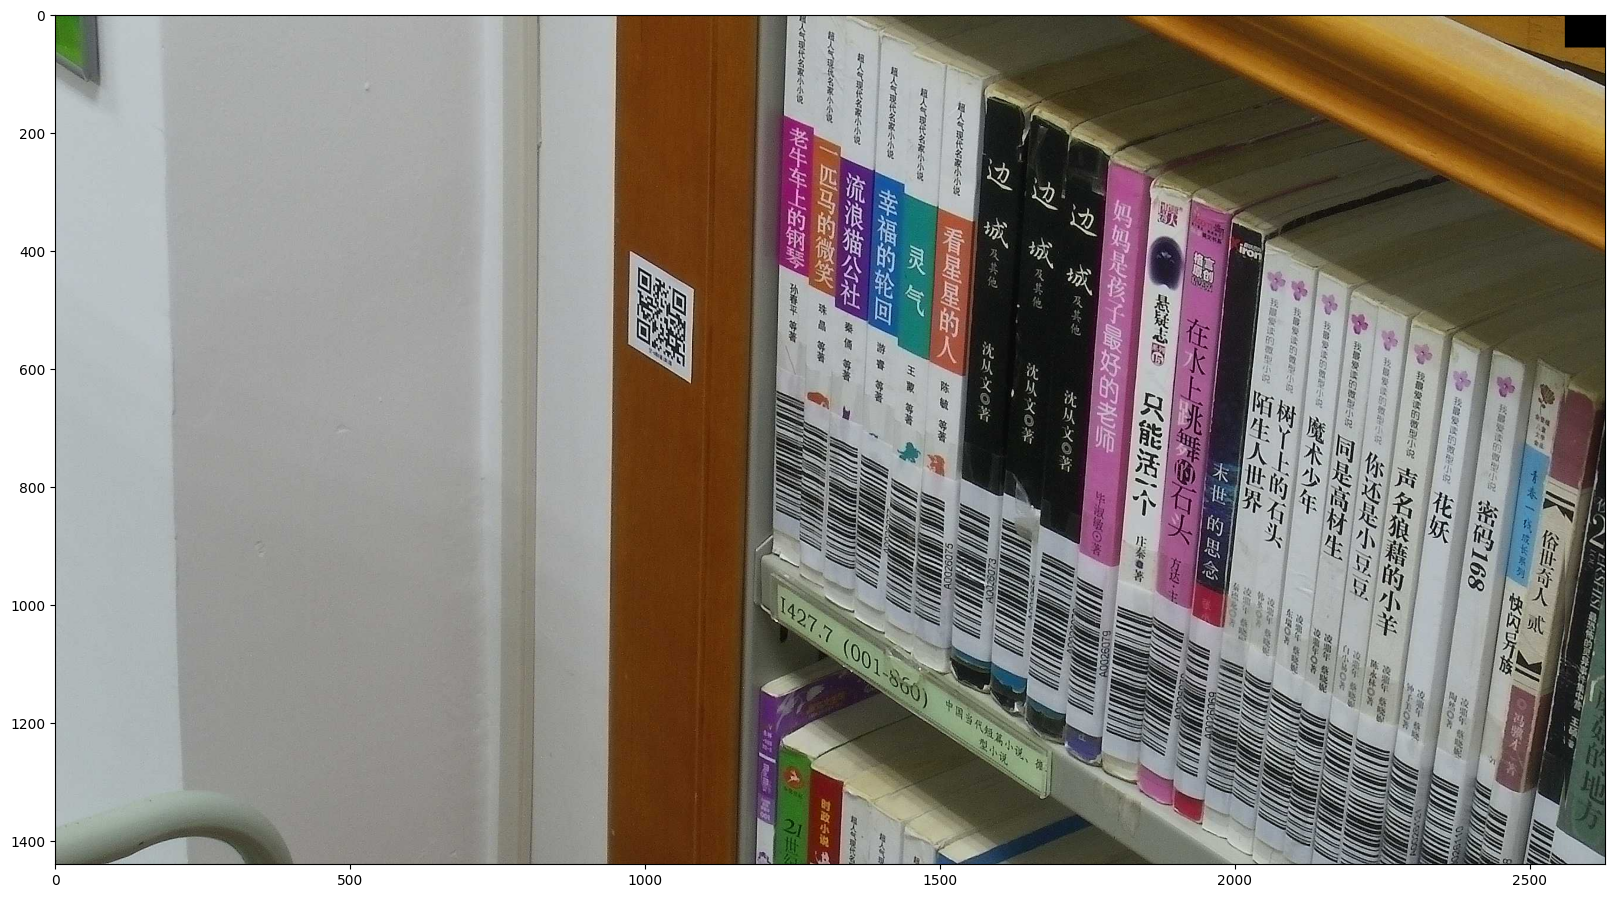

In [3]:
class stitcher:
    @staticmethod
    def detect(cv_im_bgr):
        ###################################################
        res = xfeat.detectAndCompute(cv_im_bgr)[0]
        kps, features = res["keypoints"], res["descriptors"]
        
        ####################################################
        # # 转换为灰度图像
        # cv_im_gray = cv2.cvtColor(cv_im_bgr, cv2.COLOR_BGR2GRAY)
        # # sift = cv2.SIFI_create()
        # sift = cv2.xfeatures2d.SIFT_create()
        # kps, features = sift.detectAndCompute(cv_im_gray, None)
        return kps, features
    @staticmethod
    def match(cv_im_bgr1, cv_im_bgr2, threshold):
        # ------------------------------- begin ------------------------------------
        kps1, feats1 = stitcher.detect(cv_im_bgr1)
        kps2, feats2 = stitcher.detect(cv_im_bgr2)
        index1, index2 = xfeat.match(feats1, feats2, min_cossim = 0.82)
        src_points, dst_points = kps1[index1].cpu().numpy(), kps2[index2].cpu().numpy()
        H, status = cv2.findHomography(src_points, # 源图像上的点集
                                dst_points, # 目标图像上的点集
                                cv2.RANSAC, threshold)
        
        return H
        
        # -------------------------------- end ------------------------------------
        # kps1, feats1 = stitcher.detect(cv_im_bgr1)
        # kps2, feats2 = stitcher.detect(cv_im_bgr2)
        # matcher = cv2.DescriptorMatcher_create("BruteForce")
        # matches = matcher.knnMatch(feats1,  # 查询图像的特征描述符
        #                            feats2,  # 训练图像（数据库图像）的特征描述符
        #                            k=2)     # 查询图像的每个特征点要在训练图像中找到2个最佳匹配
        
        # return kps1,kps2,matches  
    @staticmethod
    def match_keypoints(kps1,kps2,matches,ratio,threshold):
        
        # step1: 筛选匹配点
        good_l,matches_l = [], []
        for match in matches:
            #                            可见匹配的2个点还是有从 优秀-->次优秀排序的。 
            #                            如果ratio=0.8，那么对于一个（最优）匹配点，只有当它和它的下一个匹配点（次优）距离小于它的前一个匹配点距离的0.8倍时，才被保留。
            if len(match) == 2 and match[0].distance < match[1].distance * ratio:
                good_l.append(match[0])
                matches_l.append((match[0].queryIdx, match[0].trainIdx)) # （查询图像中点的索引，训练图像中点的索引）
        
        # 当匹配的特征点对数 > 4,就可以用来构建变换矩阵了
        
        kps1_coors = np.float32([kpt.pt for kpt in kps1]).tolist()
        kps2_coors = np.float32([kpt.pt for kpt in kps2]).tolist()
        print(f"len(good_l):{len(good_l)}")
        if len(good_l) > 4:
           match_kp1_l =  [kps1_coors[match[0]] for match in matches_l]
           match_kp2_l =  [kps2_coors[match[1]] for match in matches_l]
           # 计算变换矩阵(采用ransac算法从pts中选择一部分点) ==================> H作用：将原图像转换为目标图像
           H, status = cv2.findHomography(np.array(match_kp1_l), # 源图像上的点集
                                          np.array(match_kp2_l), # 目标图像上的点集
                                          cv2.RANSAC, threshold)
        
           return H,status, good_l
        return None,None,None
    
    @staticmethod
    def stitch(cv_im_bgr1, cv_im_bgr2, H, threshold=10):
        """
        cv_im_bgr1: 源图像， cv_im_bgr2: 目标图像， H: 源图像到目标图像的变换矩阵
        """
        # 获取图像尺寸
        src_h, src_w = cv_im_bgr1.shape[:2]
        dst_h, dst_w = cv_im_bgr2.shape[:2]
        # 对源图像做透视变换，由于透视变换会改变图像的尺寸，导致部分图像内容看不到，所以对图像进行扩展：
        # 高度取2图像中最高的，宽度为2者相加
        image = np.zeros((max(src_h, dst_h), src_w + dst_w + src_w , 3), dtype=np.uint8)
        image[:src_h, src_w//3:src_w+src_w//3]= cv_im_bgr1
        image = cv2.warpPerspective(image,
                                    H, 
                                    (image.shape[1], image.shape[0])) # 输出图像的尺寸，非图像内容区域用黑色像素填充
        image[0:dst_h, src_w//3:dst_w+src_w//3] = cv_im_bgr2
        
        ################################## 去掉黑边 begin######################################
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cols = gray.mean(axis=0)  # 计算每一列的平均像素值
        start_col = np.where(cols > threshold)[0][0]  # 找到第一个非黑边的列
        end_col = np.where(cols > threshold)[0][-1]   # 找到最后一个非黑边的列
        image = image[:, start_col:end_col]
        ################################## 去掉黑边 begin######################################
        return image
    
    @staticmethod
    def do(src_cv_im_bgr, dst_cv_im_bgr, ratio=0.8, threshold=3):
        H = stitcher.match(src_cv_im_bgr, dst_cv_im_bgr, threshold)
        # H,status, good = stitcher.match_keypoints(kps1,kps2,matches,ratio,threshold)
        if H is not None:
            return stitcher.stitch(src_cv_im_bgr, dst_cv_im_bgr, H)
        return None
#------------------------------------------------------------------------------------- 调用-------------------------------------------------------------------------------------
img0_pth = "/mnt/disk2/projects/expore/LoFTR-train/assets/books/wz0602001-1.jpg"
img1_pth = "/mnt/disk2/projects/expore/LoFTR-train/assets/books/wz0602001-2.jpg"

# img0_pth = r"/mnt/disk3/projects/expore/accelerated_features/assets/books/wz0602001-01-02.jpg"
# img1_pth = r"/mnt/disk3/projects/expore/accelerated_features/assets/books/wz0602001-01-03.jpg"

# img0_pth = "/mnt/disk3/projects/expore/accelerated_features/assets/book1/wz0602002-1.jpg"
# img1_pth = "/mnt/disk3/projects/expore/accelerated_features/assets/book1/wz0602002-2.jpg"

src_im = cv2.imread(img1_pth)
dst_im = cv2.imread(img0_pth)
stitch_im = stitcher.do(src_im, dst_im)
if stitch_im is not None:
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(stitch_im, cv2.COLOR_BGR2RGB))
    plt.show()